# Testing

### Imports

In [93]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras_nlp
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, TextVectorization, LSTM, Bidirectional, RNN, GlobalAveragePooling1D, Dropout

tf.get_logger().setLevel('ERROR')


## Process New

In [7]:
# keywords = [
#     'apple',
#     'meta',
#     'amazon',
#     'tesla',
#     'microsoft',
#     'google',
#     'reddit',
#     'tim cook',
#     'mark zuckerberg',
#     'jeff bezos',
#     'elon musk',
#     'satya nadella',
#     'sundar pichai',
#     'steve huffman',
# ]

In [8]:
# url = 'https://www.forbes.com/news/'
# response = requests.get(url)
# soup = BeautifulSoup(response.text, 'html.parser')
# titles = [title.text for title in soup.find_all('a', class_='_5ncu0TWl')]

In [9]:
# old_titles = []
# old_df = pd.read_json("data.json", orient='index')
# old_titles = old_df.index.tolist()
# print(old_titles)
# titles = [title for title in titles if title not in old_titles]

In [10]:
# keyed_titles = [title for title in titles if any(keyword in title.lower() for keyword in keywords)]
# my_sentiments = {}
# for title in keyed_titles:
#     my_sent = int(input(f"Please enter your sentiment for the title: {title} "))
#     my_sentiments[title] = my_sent

In [11]:
# sentiments_df = pd.DataFrame.from_dict(my_sentiments, orient='index', columns=['sentiment'])
# sentiments_df

In [12]:
# new_df = pd.concat([old_df, sentiments_df])
# new_df.to_json("data.json", orient='index')
# new_df

## Process Old

In [8]:
sentiment_key = {'positive': 1, 'neutral': .5, 'negative': 0}

In [9]:
test_data1 = pd.read_csv('data/test_data1.csv', encoding='latin-1', header=None, names=['sentiment', 'title'])
test_data1['sentiment'] = [sentiment_key[sentiment] for sentiment in test_data1['sentiment']]
test_data1 = test_data1[['title', 'sentiment']]
test_data1

,title,sentiment
0,"According to Gran , the company has no plans t...",0.5
1,Technopolis plans to develop in stages an area...,0.5
2,The international electronic industry company ...,0.0
3,With the new production plant the company woul...,1.0
4,According to the company 's updated strategy f...,1.0
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0.0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0.5
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0.0
4844,Net sales of the Paper segment decreased to EU...,0.0


In [10]:
test_data2 = pd.read_csv('data/test_data2.csv').rename(columns={'Sentence': 'title', 'Sentiment': 'sentiment'})
test_data2['sentiment'] = [sentiment_key[sentiment] for sentiment in test_data2['sentiment']]
test_data2

,title,sentiment
0,The GeoSolutions technology will leverage Bene...,1.0
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0.0
2,"For the last quarter of 2010 , Componenta 's n...",1.0
3,According to the Finnish-Russian Chamber of Co...,0.5
4,The Swedish buyout firm has sold its remaining...,0.5
...,...,...
5837,RISING costs have forced packaging producer Hu...,0.0
5838,Nordic Walking was first used as a summer trai...,0.5
5839,"According shipping company Viking Line , the E...",0.5
5840,"In the building and home improvement trade , s...",0.5


In [11]:
test_data3 = pd.read_csv('data/test_data3.csv').drop(columns=['S No.', 'Words']).rename(columns={'Title': 'title'})
sentiments3 = [list(eval(sent).values()) for sent in test_data3['Decisions']]

sent_vals3 = []
for sents in sentiments3:
    sent_vals = [sentiment_key[sent] for sent in sents]
    sent_avg = sum(sent_vals) / len(sent_vals)
    sent_vals3.append(sent_avg)

test_data3['sentiment'] = sent_vals3
test_data3.drop(columns=['Decisions'], inplace=True)
test_data3

,title,sentiment
0,SpiceJet to issue 6.4 crore warrants to promoters,0.50
1,MMTC Q2 net loss at Rs 10.4 crore,0.50
2,"Mid-cap funds can deliver more, stay put: Experts",1.00
3,Mid caps now turn into market darlings,1.00
4,"Market seeing patience, if not conviction: Pra...",0.50
...,...,...
10748,"Negative on Chambal, Advanta: Mitesh Thacker",0.00
10749,"Small, Mid-cap stocks may emerge outperformers",1.00
10750,Rupee slips against US dollar,0.25
10751,Rupee weak against US dollar,0.25


In [89]:
all_test_data = pd.concat([test_data1, test_data2, test_data3])
# all_test_data.drop(all_test_data[all_test_data['sentiment'] == 0.5].index, inplace=True)
all_test_data['sentiment'] = all_test_data['sentiment'].apply(lambda x: 1 if x > 0.5 else 0)
all_test_data.reset_index(drop=True, inplace=True)
all_test_data

,title,sentiment
0,"According to Gran , the company has no plans t...",0
1,Technopolis plans to develop in stages an area...,0
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,1
4,According to the company 's updated strategy f...,1
...,...,...
21436,"Negative on Chambal, Advanta: Mitesh Thacker",0
21437,"Small, Mid-cap stocks may emerge outperformers",1
21438,Rupee slips against US dollar,0
21439,Rupee weak against US dollar,0


## Model

In [139]:
vocab_size = 5000
max_len = 50
embedding_dim = 32
rand = 42

X = all_test_data['title']
y = all_test_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(X_train)

x_train_vec = vectorize_layer(X_train)
x_test_vec = vectorize_layer(X_test)

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(embedding_dim)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_vec, y_train, batch_size=64, epochs=10,
                    validation_data=(x_test_vec, y_test),
                    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
                    )
loss, accuracy = model.evaluate(x_test_vec, y_test)
loss, accuracy

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6949 - loss: 0.5857 - val_accuracy: 0.8433 - val_loss: 0.3669
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8956 - loss: 0.2744 - val_accuracy: 0.8704 - val_loss: 0.3199
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9276 - loss: 0.2027 - val_accuracy: 0.8734 - val_loss: 0.3243
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9446 - loss: 0.1623 - val_accuracy: 0.8746 - val_loss: 0.3339
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9553 - loss: 0.1347 - val_accuracy: 0.8781 - val_loss: 0.3569
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9646 - loss: 0.1124 - val_accuracy: 0.8753 - val_loss: 0.3755
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9716 - loss: 0.0873 - val_accuracy: 0.8767 - val_loss: 0.3773
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9758 - loss: 0.0786 - val_acc

(0.45866310596466064, 0.8745628595352173)

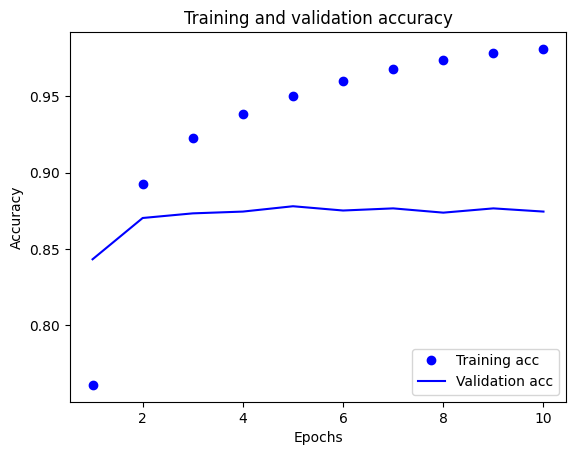

In [140]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


In [135]:
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     "distil_bert_base_en",
#     sequence_length=50,
# )
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(
#     "distil_bert_base_en",
#     num_classes=2,
#     preprocessor=preprocessor,
# )

# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(5e-5),
#     metrics=['accuracy'],
#     jit_compile=True,
# )
# history = classifier.fit(x=X_train, y=y_train, batch_size=2, epochs=2, validation_data=(X_test, y_test))
# classifier.evaluate(X_test, y_test)


In [142]:
vocab_size = 5000
max_len = 100
embedding_dim = 32
rand = 42

X = all_test_data['title']
y = all_test_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(X_train)

x_train_vec = vectorize_layer(X_train)
x_test_vec = vectorize_layer(X_test)

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_vec, y_train, batch_size=64, epochs=20,
                    validation_data=(x_test_vec, y_test),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
loss, accuracy = model.evaluate(x_test_vec, y_test)
loss, accuracy

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6555 - loss: 0.6429 - val_accuracy: 0.6682 - val_loss: 0.6246
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6643 - loss: 0.6267 - val_accuracy: 0.6682 - val_loss: 0.6123
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6655 - loss: 0.6097 - val_accuracy: 0.6822 - val_loss: 0.5912
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6766 - loss: 0.5858 - val_accuracy: 0.7144 - val_loss: 0.5591
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7172 - loss: 0.5485 - val_accuracy: 0.7193 - val_loss: 0.5279
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7613 - loss: 0.5129 - val_accuracy: 0.7734 - val_loss: 0.4947
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7932 - loss: 0.4741 - val_accuracy: 0.7673 - val_loss: 0.4687
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8123 - loss: 0.4395 - val_accuracy: 0.

(0.34180349111557007, 0.8559104800224304)

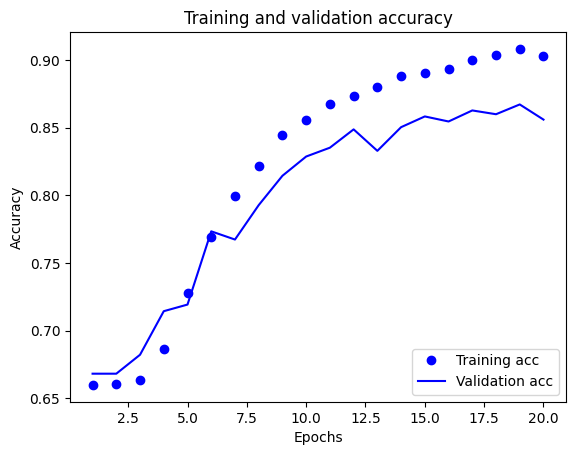

In [143]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
